In [ ]:
!pip install kaggle
!kaggle datasets download -d gyanprakashkushwaha/laptop-price-prediction-cleaned-dataset
!unzip laptop-price-prediction-cleaned-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/gyanprakashkushwaha/laptop-price-prediction-cleaned-dataset
License(s): CC0-1.0
  0% 0.00/21.5k [00:00<?, ?B/s]
100% 21.5k/21.5k [00:00<00:00, 29.2MB/s]
Archive:  laptop-price-prediction-cleaned-dataset.zip
  inflating: laptop_data_cleaned.csv  


In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d9fd0d681e14104f700953f49196b9f1ad5e8a93fa28b15ecbbffbd64581fcf8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql.functions import col, dayofmonth, month, year,  to_date, to_timestamp, weekofyear, dayofweek
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


my_spark = SparkSession.builder.appName("Laptop_price").getOrCreate()


sales_data = my_spark.read.csv(
    "laptop_data_cleaned.csv", header=True, inferSchema=True, sep=",")



In [ ]:
#uxxaki stugumner

In [ ]:
sales_data

DataFrame[Company: string, TypeName: string, Ram: int, Weight: double, Price: double, TouchScreen: int, Ips: int, Ppi: double, Cpu_brand: string, HDD: int, SSD: int, Gpu_brand: string, Os: string]

In [ ]:
sales_data.describe().show()

+-------+-------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+---------+-------+
|summary|Company|          TypeName|              Ram|            Weight|             Price|        TouchScreen|                Ips|               Ppi|           Cpu_brand|               HDD|               SSD|Gpu_brand|     Os|
+-------+-------+------------------+-----------------+------------------+------------------+-------------------+-------------------+------------------+--------------------+------------------+------------------+---------+-------+
|  count|   1273|              1273|             1273|              1273|              1273|               1273|               1273|              1273|                1273|              1273|              1273|     1273|   1273|
|   mean|   NULL|              NULL|8.447761194029852| 2.041099764336213|10.82821823

In [ ]:
sales_data.printSchema()

root
 |-- Company: string (nullable = true)
 |-- TypeName: string (nullable = true)
 |-- Ram: integer (nullable = true)
 |-- Weight: double (nullable = true)
 |-- Price: double (nullable = true)
 |-- TouchScreen: integer (nullable = true)
 |-- Ips: integer (nullable = true)
 |-- Ppi: double (nullable = true)
 |-- Cpu_brand: string (nullable = true)
 |-- HDD: integer (nullable = true)
 |-- SSD: integer (nullable = true)
 |-- Gpu_brand: string (nullable = true)
 |-- Os: string (nullable = true)



In [ ]:
sales_data.show()

+-------+---------+---+------+------------------+-----------+---+------------------+--------------------+----+---+---------+-------+
|Company| TypeName|Ram|Weight|             Price|TouchScreen|Ips|               Ppi|           Cpu_brand| HDD|SSD|Gpu_brand|     Os|
+-------+---------+---+------+------------------+-----------+---+------------------+--------------------+----+---+---------+-------+
|  Apple|Ultrabook|  8|  1.37|11.175754549129524|          0|  1|226.98300468106115|       Intel Core i5|   0|128|    Intel|    Mac|
|  Apple|Ultrabook|  8|  1.34| 10.77677731765335|          0|  0|127.67794013309688|       Intel Core i5|   0|  0|    Intel|    Mac|
|     HP| Notebook|  8|  1.86|10.329931067029484|          0|  0|141.21199808219862|       Intel Core i5|   0|256|    Intel| Others|
|  Apple|Ultrabook| 16|  1.83|11.814475944954545|          0|  1|220.53462386625827|       Intel Core i7|   0|512|      AMD|    Mac|
|  Apple|Ultrabook|  8|  1.37|11.473100972779063|          0|  1|226.

#Ինդեքսավորում եմ ընտրված սյուները

In [ ]:
Company_index = StringIndexer(inputCol='Company', outputCol='Company_index')
Gpu_brand_index = StringIndexer(inputCol='Gpu_brand', outputCol='Gpu_brand_index')

In [ ]:
sales_data_index = Company_index.fit(sales_data).transform(sales_data)
sales_data_index = Gpu_brand_index.fit(sales_data_index).transform(sales_data_index)

In [ ]:
sales_data_index.show()

+-------+---+-----------+---------+------------------+-------------+---------------+
|Company|Ram|TouchScreen|Gpu_brand|             Price|Company_index|Gpu_brand_index|
+-------+---+-----------+---------+------------------+-------------+---------------+
|  Apple|  8|          0|    Intel|11.175754549129524|          7.0|            0.0|
|  Apple|  8|          0|    Intel| 10.77677731765335|          7.0|            0.0|
|     HP|  8|          0|    Intel|10.329931067029484|          2.0|            0.0|
|  Apple| 16|          0|      AMD|11.814475944954545|          7.0|            2.0|
|  Apple|  8|          0|    Intel|11.473100972779063|          7.0|            0.0|
|   Acer|  4|          0|      AMD| 9.967025573340116|          4.0|            2.0|
|  Apple| 16|          0|    Intel| 11.64410811545818|          7.0|            0.0|
|  Apple|  8|          0|    Intel| 11.03061499223515|          7.0|            0.0|
|   Asus| 16|          0|   Nvidia|11.285442512056921|          3

#Onehot encode-եմ անում

In [ ]:
onehot = OneHotEncoder(inputCols=['Company_index','Gpu_brand_index'], outputCols=['Company_dummy','Gpu_brand_dummy'])

onehot = onehot.fit(sales_data_index)
sales_data_onehot = onehot.transform(sales_data_index)

In [ ]:
sales_data_onehot.show()

+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+
|Company|Ram|TouchScreen|Gpu_brand|             Price|Company_index|Gpu_brand_index| Company_dummy|Gpu_brand_dummy|
+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+
|  Apple|  8|          0|    Intel|11.175754549129524|          7.0|            0.0|(18,[7],[1.0])|  (2,[0],[1.0])|
|  Apple|  8|          0|    Intel| 10.77677731765335|          7.0|            0.0|(18,[7],[1.0])|  (2,[0],[1.0])|
|     HP|  8|          0|    Intel|10.329931067029484|          2.0|            0.0|(18,[2],[1.0])|  (2,[0],[1.0])|
|  Apple| 16|          0|      AMD|11.814475944954545|          7.0|            2.0|(18,[7],[1.0])|      (2,[],[])|
|  Apple|  8|          0|    Intel|11.473100972779063|          7.0|            0.0|(18,[7],[1.0])|  (2,[0],[1.0])|
|   Acer|  4|          0|      AMD| 9.967025573340116|          4.0|    

# feature սյունն եմ ստեղծում, որ արդեն train արվի

In [ ]:
assembler = VectorAssembler(inputCols=[
    'Ram',
    'Weight',
    'TouchScreen',
    'Ips',
    'Ppi',
], outputCol='features')

flights_assembled = assembler.transform(sales_data)

flights_assembled.select('features', 'Price').show(5, truncate=False)

+--------------------------------------+------------------+
|features                              |Price             |
+--------------------------------------+------------------+
|[8.0,1.37,0.0,1.0,226.98300468106115] |11.175754549129524|
|[8.0,1.34,0.0,0.0,127.67794013309688] |10.77677731765335 |
|[8.0,1.86,0.0,0.0,141.21199808219862] |10.329931067029484|
|[16.0,1.83,0.0,1.0,220.53462386625827]|11.814475944954545|
|[8.0,1.37,0.0,1.0,226.98300468106115] |11.473100972779063|
+--------------------------------------+------------------+
only showing top 5 rows



In [ ]:
#uxxaki stugumneri avart :)

#Թեթև վիզուալիզացիա

In [ ]:
sales_data = sales_data.select(col('Company'),col('Ram'), col('TouchScreen'),col('Gpu_brand'), col('Price'))

In [ ]:
sales_data_df = sales_data.toPandas()

In [ ]:
mean_prices = sales_data_df.groupby('Company')['Price'].mean().sort_values(ascending=False)
mean_prices

Company
Razer        11.940528
LG           11.621737
MSI          11.383340
Google       11.374981
Microsoft    11.305010
Apple        11.274645
Huawei       11.235397
Samsung      11.173723
Toshiba      11.044669
Xiaomi       10.995970
Dell         10.924479
HP           10.805129
Asus         10.797073
Lenovo       10.779085
Fujitsu      10.563592
Acer         10.301821
Chuwi         9.683992
Mediacom      9.645522
Vero          9.351166
Name: Price, dtype: float64

In [ ]:
company_counts = sales_data_df['Company'].value_counts()[:5]
company_counts

Company
Dell      291
Lenovo    289
HP        268
Asus      151
Acer      101
Name: count, dtype: int64

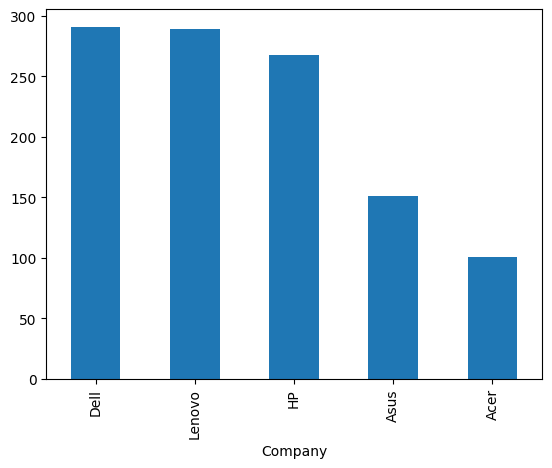

In [ ]:
company_counts.plot(kind='bar')
plt.show()

#Բաժանում եմ դատան

In [ ]:
train_data , test_data = sales_data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
test_data.count()

269

In [ ]:
Company_index = StringIndexer(inputCol='Company', outputCol='Company_index')
Gpu_brand_index = StringIndexer(inputCol='Gpu_brand', outputCol='Gpu_brand_index')

In [ ]:
onehot = OneHotEncoder(inputCols=['Company_index','Gpu_brand_index'], outputCols=['Company_dummy','Gpu_brand_dummy'])

In [ ]:
feature_cols = ['Ram', 'TouchScreen', 'Company_dummy', 'Gpu_brand_dummy']

In [ ]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

In [ ]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="Price",
    maxBins=4000)

#Pipeline եմ սարքում randomForest-ի համար

In [ ]:
pipeline = Pipeline(stages=[Company_index, Gpu_brand_index, onehot, assembler, rf])

In [ ]:
model = pipeline.fit(train_data)

In [ ]:
preds = model.transform(test_data)

In [ ]:
preds.show()

+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+--------------------+------------------+
|Company|Ram|TouchScreen|Gpu_brand|             Price|Company_index|Gpu_brand_index| Company_dummy|Gpu_brand_dummy|            features|        prediction|
+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+--------------------+------------------+
|   Acer|  2|          0|    Intel|  9.77465368069266|          4.0|            0.0|(18,[4],[1.0])|  (2,[0],[1.0])|(22,[0,6,20],[2.0...| 9.676617464441353|
|   Acer|  4|          0|      AMD|10.030000372501505|          4.0|            2.0|(18,[4],[1.0])|      (2,[],[])|(22,[0,6],[4.0,1.0])|10.142879466691038|
|   Acer|  4|          0|    Intel| 9.317895278196945|          4.0|            0.0|(18,[4],[1.0])|  (2,[0],[1.0])|(22,[0,6,20],[4.0...|10.097794877628234|
|   Acer|  4|          0|    Intel| 9.672654512737537|          

Error-ներ եմ գտնում

In [ ]:
mae_eval = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="mae")

In [ ]:
mae = mae_eval.evaluate(preds)

In [ ]:
mae

0.28413011760651025

In [ ]:
rmse_eval = RegressionEvaluator(labelCol="Price", predictionCol="prediction", metricName="rmse")

In [ ]:
rmse = rmse_eval.evaluate(preds)

In [ ]:
rmse

0.354863450154745

Նոր Pipeline եմ սարքում pipeline1, որ բերեմ դատան իմ ուզած տեսքի հետո նույն տրանսֆորմացիան անում եմ թեստի վրա, հետո CrossValidation եմ անում և ընտրում լավագույն մոդելը predict անելու համար

In [ ]:
pipeline1 = Pipeline(stages=[Company_index, Gpu_brand_index, onehot, assembler])
pipeline1 = pipeline1.fit(train_data)
train_data_transformed = pipeline1.transform(train_data)
test_data_transformed = pipeline1.transform(test_data)

In [ ]:
params = ParamGridBuilder().build()
params1 = ParamGridBuilder().addGrid(rf.maxDepth, [3, 5, 7]).addGrid(rf.numTrees, [10, 20, 30]).build()

In [ ]:
cv = CrossValidator(estimator=rf,
          estimatorParamMaps=params1,
          evaluator=mae_eval)

In [ ]:
cv = cv.fit(train_data_transformed)

In [ ]:
cv.avgMetrics

[0.3314682321479273,
 0.32802763195017665,
 0.3280889141825391,
 0.30295615985717855,
 0.29980882276115056,
 0.3017677212735988,
 0.29069031247049587,
 0.2876858015690524,
 0.29038911193923306]

In [ ]:
cv.bestModel

RandomForestRegressionModel: uid=RandomForestRegressor_a9f72a79b6be, numTrees=20, numFeatures=22

In [ ]:
cv_pred = cv.bestModel.transform(test_data_transformed)
cv_pred.show()

+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+--------------------+------------------+
|Company|Ram|TouchScreen|Gpu_brand|             Price|Company_index|Gpu_brand_index| Company_dummy|Gpu_brand_dummy|            features|        prediction|
+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+--------------------+------------------+
|   Acer|  2|          0|    Intel|  9.77465368069266|          4.0|            0.0|(18,[4],[1.0])|  (2,[0],[1.0])|(22,[0,6,20],[2.0...| 9.537247731568208|
|   Acer|  4|          0|      AMD|10.030000372501505|          4.0|            2.0|(18,[4],[1.0])|      (2,[],[])|(22,[0,6],[4.0,1.0])|10.089544173103898|
|   Acer|  4|          0|    Intel| 9.317895278196945|          4.0|            0.0|(18,[4],[1.0])|  (2,[0],[1.0])|(22,[0,6,20],[4.0...|10.075610050085647|
|   Acer|  4|          0|    Intel| 9.672654512737537|          

In [ ]:
regression = LinearRegression(labelCol='Price', featuresCol='features',predictionCol='prediction')

In [ ]:
cv_reg = CrossValidator(estimator=regression,
          estimatorParamMaps=params,
          evaluator=mae_eval)
cv_reg = cv_reg.fit(train_data_transformed)

In [ ]:
cv_pred_reg = cv_reg.bestModel.transform(test_data_transformed)
cv_pred_reg.show()

+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+--------------------+------------------+
|Company|Ram|TouchScreen|Gpu_brand|             Price|Company_index|Gpu_brand_index| Company_dummy|Gpu_brand_dummy|            features|        prediction|
+-------+---+-----------+---------+------------------+-------------+---------------+--------------+---------------+--------------------+------------------+
|   Acer|  2|          0|    Intel|  9.77465368069266|          4.0|            0.0|(18,[4],[1.0])|  (2,[0],[1.0])|(22,[0,6,20],[2.0...| 9.967304918227674|
|   Acer|  4|          0|      AMD|10.030000372501505|          4.0|            2.0|(18,[4],[1.0])|      (2,[],[])|(22,[0,6],[4.0,1.0])| 9.922254178793303|
|   Acer|  4|          0|    Intel| 9.317895278196945|          4.0|            0.0|(18,[4],[1.0])|  (2,[0],[1.0])|(22,[0,6,20],[4.0...| 10.10020497336003|
|   Acer|  4|          0|    Intel| 9.672654512737537|          

In [ ]:
my_spark.stop()

NameError: name 'my_spark' is not defined